In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# from scipy import signal
# from scipy.io import wavfile

from tqdm import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

print(device)

cpu


In [36]:
from IPython.display import Audio, display, clear_output

def play_audio(y, sr, autoplay=False):
    display(Audio(y, rate=sr, autoplay=autoplay))
    
def audio_to_spectrogram(y, sr, normalize=False):
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    if normalize:
        spectrogram = np.interp(spectrogram, (-80., 0.), (-1., +1.))
    return spectrogram
def audios_to_spectrograms(ys, sr, normalize=False):
    spectrograms = []
    for y in ys:
        spectrograms.append(audio_to_spectrogram(y, sr, normalize))
    return np.array(spectrograms)
def spectrogram_to_audio(spectrogram, sr, normalize=False):
    if normalize:
        spectrogram = np.interp(spectrogram, (-1., +1.), (-80., 0.))
    spectrogram = librosa.db_to_power(spectrogram)
    yp = librosa.feature.inverse.mel_to_audio(spectrogram, sr=sr)
    return yp

# def my_audio_to_spectrogram(y, sr):
#     return librosa.stft(y)

# def my_spectrogram_to_audio(spectrogram, sr):
#     return librosa.istft(spectrogram)


def add_spectrograms(*spectrograms, normalize=False):
    result = np.zeros_like(spectrograms[0])
    for spectrogram in spectrograms:
        if normalize:
            spectrogram = np.interp(spectrogram, (-1., +1.), (-80., 0.))
        result += librosa.db_to_power(spectrogram)
    result = librosa.power_to_db(result)
    if normalize:
        result = np.interp(result, (-80., 0.), (-1., +1.))
    return result
# first - second - third, etc.
def subtract_spectrograms(*spectrograms, normalize=False):
    result = spectrograms[0]
    if normalize:
        result = np.interp(result, (-1., +1.), (-80., 0.))
    result = librosa.db_to_power(result)

    for i in range(1, len(spectrograms)):
        spectrogram = spectrograms[i]
        if normalize:
            spectrogram = np.interp(spectrogram, (-1., +1.), (-80., 0.))
        result -= librosa.db_to_power(spectrogram)
    result = librosa.power_to_db(result)
    if normalize:
        result = np.interp(result, (-80., 0.), (-1., +1.))
    return result



def show_audio(y, sr):
    librosa.display.waveplot(y=y, sr=sr)

def show_spectrogram(spectrogram, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', sr=sr, fmax=8000, cmap='gray')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.colorbar()

In [ ]:
y, sr = librosa.load('samples/bee.wav', sr=None, mono=True, offset=0.0, duration=None)
print('sample rate: ',sr)
print('y.shape', y.shape)

In [37]:
y, sr = librosa.load('/Users/akarshkumar0101/Developer/Class/DSProject/datasets/LibriSpeech/LibriSpeech/dev-clean/2078/142845/2078-142845-0036.flac', sr=None, mono=True, offset=0.0, duration=None)
print('sample rate: ',sr)
print('y.shape', y.shape)

sample rate:  16000
y.shape (59520,)


In [ ]:
y, sr = librosa.load(librosa.util.example_audio_file(), sr=None, mono=True, offset=0.0, duration=None)
print('sample rate: ',sr)
print('y.shape', y.shape)

In [ ]:
sr = 10000
full = np.arange(sr*10)
y = np.sin(0.3*full)#*np.sqrt(full))
y2 = np.sin(0.5*full)
del full

# y=y[0:500]
print('sample rate: ',sr)
print('y.shape', y.shape)



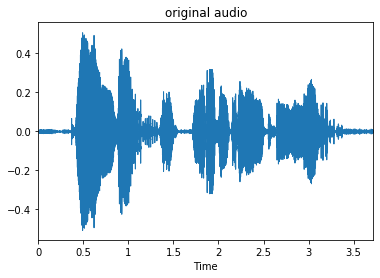

In [38]:
show_audio(y, sr)
plt.title('original audio')
plt.show()

play_audio(y, sr)

In [ ]:
spectrogram = audio_to_spectrogram(y, sr, normalize=True)

show_spectrogram(spectrogram, sr)
plt.show()

In [ ]:
yp = spectrogram_to_audio(spectrogram, sr, normalize=True)
show_audio(yp, sr)
plt.title('reconstructed audio')
plt.show()
play_audio(yp, sr)

In [41]:
y_noise = 0.3*np.sin(0.2 * np.arange(len(y)))

sy1 = audio_to_spectrogram(y, sr)
sy2 = audio_to_spectrogram(y_noise, sr)
sz = audio_to_spectrogram(y+y_noise, sr)
sz2 = add_spectrograms(sy1, sy2)

sy1re = subtract_spectrograms(sz2, sy2)


#     spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
#     spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
#     if normalize:
#         spectrogram = np.interp(spectrogram, (-80., 0.), (-1., +1.))


# spectrogram = librosa.db_to_power(spectrogram)
#     yp = librosa.feature.inverse.mel_to_audio(spectrogram, sr=sr)

play_audio(y+y_noise, sr)
# play_audio(spectrogram_to_audio(sz, sr), sr)

# play_audio(spectrogram_to_audio(sz2, sr), sr)
play_audio(spectrogram_to_audio(sy1re, sr), sr)




In [3]:
import os
voice_dir = 'datasets/LibriSpeech/LibriSpeech/dev-clean'
noise_dir = 'datasets/urban/UrbanSound8K/audio'

voice_files, noise_files = [], []

for r, d, f in os.walk(voice_dir):
    for file in f:
        if file.endswith('.flac'):
            voice_files.append(os.path.join(r, file))

for r, d, f in os.walk(noise_dir):
    for file in f:
        if file.endswith('.wav'):
            noise_files.append(os.path.join(r, file))


In [4]:
global current_voice_i
global current_noise_i
current_voice_i = 0
current_noise_i = 0

sr = 10000
duration = 5
sample_length = duration * sr


def set_sample_length(y, sample_length):
    if len(y) > sample_length:
        y = y[:sample_length]
    if len(y) < sample_length:
        factor = sample_length//len(y)
        oy = y.copy()
        for i in range(factor-1):
            y = np.concatenate((y, oy), axis=0)
        leftover = sample_length - len(y)
        y = np.concatenate((y, oy[:leftover]), axis=0)
    return y

def load_voice_batch(batch_num):
    global current_voice_i
    i = current_voice_i % len(voice_files)
    files = voice_files[i: i+batch_num]
    current_voice_i += batch_num
    
    ys = []
    for file in files:
        y, _ = librosa.load(file, sr=sr, mono=True, offset=0.0, duration=None)
        y = set_sample_length(y, sample_length)
        ys.append(y)
    return np.array(ys)
    
def load_noise_batch(batch_num):
    global current_noise_i
    i = current_noise_i % len(noise_files)
    files = noise_files[i: i+batch_num]
    current_noise_i += batch_num
    
    ys = []
    for file in files:
        y, _ = librosa.load(file, sr=sr, mono=True, offset=0.0, duration=None)
        y = set_sample_length(y, sample_length)
        ys.append(y)
    return np.array(ys)




In [26]:
X_voice_test = load_voice_batch(100)
X_noise_test = load_noise_batch(100)

Y_voice_test = np.ones(X_voice_test.shape[0])
Y_noise_test = np.zeros(X_noise_test.shape[0])

X_test = np.concatenate((X_voice_test, X_noise_test), axis=0)
Y_test = np.concatenate((Y_voice_test, Y_noise_test), axis=0)

X_test = audios_to_spectrograms(X_test, sr)[:, None, :, :]

X_test = torch.from_numpy(X_test).to(device, dtype)
Y_test = torch.from_numpy(Y_test).to(device, dtype)

In [8]:
class VoiceRecogNet(nn.Module):
    def __init__(self):
        super(VoiceRecogNet, self).__init__()
        self.maxpool = nn.MaxPool2d((2,2))
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        self.linear = nn.Linear(12288, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv2(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv3(x)
        x = self.maxpool(x)
        x = torch.tanh(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.linear(x)
        x = torch.relu(x)
        
        x = self.linear2(x)
        x = torch.relu(x)
        
        x = self.linear3(x)
        x = torch.sigmoid(x)
        
        return x
    
vrn = VoiceRecogNet().to(device)

In [31]:
crit = nn.BCELoss()

Y_test_pred = vrn.forward(X_test)[:, 0]
print('BSE: ', crit(Y_test_pred, Y_test))

Y_test_pred_ = Y_test_pred.detach().cpu().numpy()
Y_test_ = Y_test.detach().cpu().numpy()

accuracy = ((Y_test_pred_>0.5) == (Y_test_>0.5)).sum()/len(Y_test)
print('accuracy: ', accuracy)


del Y_test_pred_
del Y_test_


BSE:  tensor(0.6953, grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  0.5


  1%|          | 1/100 [00:01<01:56,  1.18s/it]

0.6950116


  2%|▏         | 2/100 [00:02<01:58,  1.21s/it]

0.7005


  3%|▎         | 3/100 [00:03<02:01,  1.25s/it]

0.6929153


  4%|▍         | 4/100 [00:05<01:59,  1.25s/it]

0.69280535


  5%|▌         | 5/100 [00:06<01:53,  1.19s/it]

0.6921701


  6%|▌         | 6/100 [00:07<02:00,  1.28s/it]

0.68005717


  7%|▋         | 7/100 [00:09<02:05,  1.35s/it]

0.664938


  8%|▊         | 8/100 [00:10<02:05,  1.36s/it]

0.65045905


  9%|▉         | 9/100 [00:11<02:06,  1.39s/it]

0.5871561


 10%|█         | 10/100 [00:13<02:10,  1.44s/it]

0.6481009


 11%|█         | 11/100 [00:14<02:05,  1.41s/it]

0.6095299


 12%|█▏        | 12/100 [00:16<02:13,  1.51s/it]

0.5952912


 13%|█▎        | 13/100 [00:18<02:10,  1.50s/it]

0.5355832


 14%|█▍        | 14/100 [00:19<02:10,  1.52s/it]

0.44932455


 15%|█▌        | 15/100 [00:21<02:21,  1.66s/it]

0.44760266


 16%|█▌        | 16/100 [00:23<02:25,  1.73s/it]

0.3924951


 17%|█▋        | 17/100 [00:25<02:26,  1.76s/it]

0.49368006


 18%|█▊        | 18/100 [00:26<02:18,  1.69s/it]

0.42083007


 19%|█▉        | 19/100 [00:28<02:21,  1.74s/it]

0.31278738


 20%|██        | 20/100 [00:29<02:06,  1.58s/it]

0.5216366


 21%|██        | 21/100 [00:31<02:05,  1.59s/it]

0.1751228


 22%|██▏       | 22/100 [00:32<01:57,  1.51s/it]

0.275366


 23%|██▎       | 23/100 [00:34<01:56,  1.51s/it]

0.27353096


 24%|██▍       | 24/100 [00:35<01:52,  1.48s/it]

0.5314638


 25%|██▌       | 25/100 [00:37<01:51,  1.49s/it]

0.42363366


 26%|██▌       | 26/100 [00:38<01:54,  1.55s/it]

0.3417157


 27%|██▋       | 27/100 [00:40<01:49,  1.51s/it]

0.513268


 28%|██▊       | 28/100 [00:41<01:49,  1.52s/it]

0.3484953


 29%|██▉       | 29/100 [00:43<01:48,  1.52s/it]

0.54866064


 30%|███       | 30/100 [00:45<01:49,  1.56s/it]

0.43251553


 31%|███       | 31/100 [00:47<01:57,  1.71s/it]

0.20205943


 32%|███▏      | 32/100 [00:49<02:11,  1.93s/it]

0.23717125


 33%|███▎      | 33/100 [00:51<02:10,  1.94s/it]

0.32301107


 34%|███▍      | 34/100 [00:53<02:00,  1.82s/it]

0.17093417


 35%|███▌      | 35/100 [00:55<02:14,  2.06s/it]

0.16514832


 36%|███▌      | 36/100 [00:57<02:08,  2.01s/it]

0.44607276


 37%|███▋      | 37/100 [00:59<02:05,  2.00s/it]

0.09134931


 38%|███▊      | 38/100 [01:01<01:54,  1.85s/it]

0.35406804


 39%|███▉      | 39/100 [01:02<01:49,  1.80s/it]

0.1467063


 40%|████      | 40/100 [01:04<01:43,  1.73s/it]

0.2254465


 41%|████      | 41/100 [01:06<01:41,  1.72s/it]

0.06596959


 42%|████▏     | 42/100 [01:07<01:34,  1.63s/it]

0.5093829


 43%|████▎     | 43/100 [01:09<01:31,  1.60s/it]

0.381126


 44%|████▍     | 44/100 [01:10<01:30,  1.61s/it]

0.2748249


 45%|████▌     | 45/100 [01:12<01:33,  1.71s/it]

0.24106407


 46%|████▌     | 46/100 [01:13<01:23,  1.55s/it]

0.07235019


 47%|████▋     | 47/100 [01:15<01:19,  1.50s/it]

0.2322317


 48%|████▊     | 48/100 [01:16<01:15,  1.45s/it]

0.11137853


 49%|████▉     | 49/100 [01:17<01:13,  1.44s/it]

0.05932079


 50%|█████     | 50/100 [01:19<01:15,  1.51s/it]

0.058953058


 51%|█████     | 51/100 [01:21<01:22,  1.68s/it]

0.06717755


 52%|█████▏    | 52/100 [01:22<01:15,  1.57s/it]

0.064868905


 53%|█████▎    | 53/100 [01:24<01:13,  1.57s/it]

0.3886314


 54%|█████▍    | 54/100 [01:25<01:10,  1.52s/it]

0.17753814


 55%|█████▌    | 55/100 [01:27<01:11,  1.58s/it]

0.14049865


 56%|█████▌    | 56/100 [01:29<01:09,  1.57s/it]

0.050185442


 57%|█████▋    | 57/100 [01:30<01:04,  1.50s/it]

0.13819537


 58%|█████▊    | 58/100 [01:32<01:06,  1.57s/it]

0.04870911


 59%|█████▉    | 59/100 [01:33<01:01,  1.49s/it]

0.111616656


 60%|██████    | 60/100 [01:35<00:58,  1.47s/it]

0.25314382


 61%|██████    | 61/100 [01:36<00:58,  1.50s/it]

0.108665645


 62%|██████▏   | 62/100 [01:37<00:54,  1.43s/it]

0.37341368


 63%|██████▎   | 63/100 [01:39<00:52,  1.43s/it]

0.26825562


 64%|██████▍   | 64/100 [01:40<00:47,  1.32s/it]

0.40891185


 65%|██████▌   | 65/100 [01:41<00:47,  1.36s/it]

0.3268975


 66%|██████▌   | 66/100 [01:43<00:49,  1.45s/it]

0.058930404


 67%|██████▋   | 67/100 [01:44<00:48,  1.47s/it]

0.21746436


 68%|██████▊   | 68/100 [01:46<00:44,  1.40s/it]

0.028998757


 69%|██████▉   | 69/100 [01:47<00:43,  1.40s/it]

0.19476572


 70%|███████   | 70/100 [01:49<00:42,  1.40s/it]

0.26723793


 71%|███████   | 71/100 [01:50<00:39,  1.35s/it]

0.08887753


 72%|███████▏  | 72/100 [01:51<00:38,  1.37s/it]

0.029230133


 73%|███████▎  | 73/100 [01:53<00:37,  1.38s/it]

0.5421774


 74%|███████▍  | 74/100 [01:54<00:34,  1.32s/it]

0.09355165


 75%|███████▌  | 75/100 [01:55<00:31,  1.25s/it]

0.40220118


 76%|███████▌  | 76/100 [01:56<00:29,  1.24s/it]

0.113727316


 77%|███████▋  | 77/100 [01:58<00:31,  1.38s/it]

0.07355892


 78%|███████▊  | 78/100 [01:59<00:31,  1.44s/it]

0.03232789


 79%|███████▉  | 79/100 [02:01<00:33,  1.62s/it]

0.015360156


 80%|████████  | 80/100 [02:03<00:33,  1.67s/it]

0.014040436


 81%|████████  | 81/100 [02:05<00:32,  1.70s/it]

0.019833457


 82%|████████▏ | 82/100 [02:07<00:29,  1.66s/it]

0.048039068


 83%|████████▎ | 83/100 [02:08<00:27,  1.60s/it]

0.51372087


 84%|████████▍ | 84/100 [02:10<00:26,  1.68s/it]

0.09573029


 85%|████████▌ | 85/100 [02:11<00:24,  1.62s/it]

0.008739835


 86%|████████▌ | 86/100 [02:13<00:22,  1.62s/it]

0.5732868


 87%|████████▋ | 87/100 [02:14<00:20,  1.57s/it]

0.5128746


 88%|████████▊ | 88/100 [02:16<00:18,  1.58s/it]

0.022115111


 89%|████████▉ | 89/100 [02:18<00:17,  1.59s/it]

0.25723028


 90%|█████████ | 90/100 [02:19<00:16,  1.61s/it]

0.1791815


 91%|█████████ | 91/100 [02:21<00:14,  1.59s/it]

0.30314508


 92%|█████████▏| 92/100 [02:22<00:12,  1.60s/it]

0.13936114


 93%|█████████▎| 93/100 [02:24<00:10,  1.46s/it]

0.24437526


 94%|█████████▍| 94/100 [02:25<00:09,  1.54s/it]

0.11811306


 95%|█████████▌| 95/100 [02:27<00:07,  1.53s/it]

0.15644363


 96%|█████████▌| 96/100 [02:28<00:06,  1.56s/it]

0.030061588


 97%|█████████▋| 97/100 [02:31<00:05,  1.72s/it]

0.04541818


 98%|█████████▊| 98/100 [02:32<00:03,  1.75s/it]

0.0667172


 99%|█████████▉| 99/100 [02:34<00:01,  1.71s/it]

0.046044327


100%|██████████| 100/100 [02:36<00:00,  1.56s/it]

0.02837711


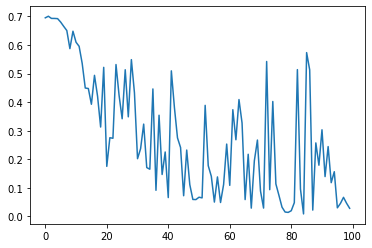

In [33]:
crit = nn.BCELoss()
losses = []
batch_num = 5
for epoch in tqdm(range(100)):
    X_voice_batch = load_voice_batch(batch_num)
    X_noise_batch = load_noise_batch(batch_num)
    Y_voice_batch = np.ones(X_voice_batch.shape[0])
    Y_noise_batch = np.zeros(X_noise_batch.shape[0])
    
    X_batch = np.concatenate((X_voice_batch, X_noise_batch), axis=0)
    Y_batch = np.concatenate((Y_voice_batch, Y_noise_batch), axis=0)
    
    X_batch = audios_to_spectrograms(X_batch, sr)[:, None, :, :]
    
    X_batch = torch.from_numpy(X_batch).to(device, dtype)
    Y_batch = torch.from_numpy(Y_batch).to(device, dtype)
    
    
    vrn.opt.zero_grad()
    Y = vrn.forward(X_batch)[:, 0]
    loss = crit(Y, Y_batch)
    
    loss.backward()
    
    vrn.opt.step()
    
    losses.append(loss.detach().cpu().numpy())
    print(loss.detach().cpu().numpy())
    
plt.plot(np.arange(len(losses)), losses)

In [34]:
crit = nn.BCELoss()

Y_test_pred = vrn.forward(X_test)[:, 0]
print('BSE: ', crit(Y_test_pred, Y_test))

Y_test_pred_ = Y_test_pred.detach().cpu().numpy()
Y_test_ = Y_test.detach().cpu().numpy()

accuracy = ((Y_test_pred_>0.5) == (Y_test_>0.5)).sum()/len(Y_test)
print('accuracy: ', accuracy)


del Y_test_pred_
del Y_test_


BSE:  tensor(0.2877, grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  0.935


In [42]:
class VoiceIsolaterNet(nn.Module):
    def __init__(self):
        super(VoiceIsolaterNet, self).__init__()
        self.maxpool = nn.MaxPool((2,2))
        self.maxunpool = nn.MaxUnpool2d((2,2))
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        
        self.linear = nn.Linear(12288, 100)
        self.linear2 = nn.Linear(100, 12288)
        
        self.convt1 = nn.ConvTranspose2d(64, 16, 3, padding=1)
        self.convt2 = nn.ConvTranspose2d(16, 4, 3, padding=1)
        self.convt3 = nn.ConvTranspose2d(4, 1, 3, padding=1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv2(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv3(x)
        x = self.maxpool(x)
        x = torch.tanh(x)
        
        sh = x.shape
        y = x.view(x.shape[0], -1)
        y = self.linear1(y)
        y = torch.relu(y)
        
        y = self.linear2(y)
        y = torch.relu(y)
        
        y = y.view(sh)
        
        
        x = x+y
        x = self.maxunpool(x)
        x = self.convt1(x)
        x = torch.tanh(x)
        
        x = self.maxunpool(x)        
        x = self.convt2(x)
        x = torch.tanh(x)
        
        x = self.maxunpool(x)
        x = self.convt3(x)
        x = torch.tanh(x)
        
        return x
    
vin = VoiceIsolaterNet().to(device)

In [ ]:

vin.forward(X_batch)[:, 0]


In [ ]:
crit = nn.MSELoss()
losses = []

batch_num = 5

for epoch in tqdm(range(100)):
    X_voice_batch = load_voice_batch(batch_num)
    X_noise_batch = load_noise_batch(batch_num)
    
    X_batch = X_voice_batch + X_noise_batch
    X_batch = audios_to_spectrograms(X_batch, sr)[:, None, :, :]
    
    Y_batch = audios_to_spectrograms(X_voice_batch)[:, None, :, :]
    
    X_batch = torch.from_numpy(X_batch).to(device, dtype)
    Y_batch = torch.from_numpy(Y_batch).to(device, dtype)
    
    
    vin.opt.zero_grad()
    Y = vin.forward(X_batch)[:, 0]
    loss = crit(Y, Y_batch)
    
    loss.backward()
    
    vin.opt.step()
    
    losses.append(loss.detach().cpu().numpy())
    print(loss.detach().cpu().numpy())
    
plt.plot(np.arange(len(losses)), losses)

In [ ]:
class TempNet(nn.Module):
    def __init__(self):
        super(TempNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, padding=1)
        self.conv2 = nn.Conv2d(2, 4, 3, padding=1)
        self.conv3 = nn.Conv2d(4, 8, 3, padding=1)
        
        self.convt1 = nn.ConvTranspose2d(8, 4, 3, padding=1)
        self.convt2 = nn.ConvTranspose2d(4, 2, 3, padding=1)
        self.convt3 = nn.ConvTranspose2d(2, 1, 3, padding=1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)
        x = torch.tanh(x)
        
        return x
    
tn = TempNet().to(device)

In [ ]:
X = torch.from_numpy(spectrogram)[None, None, ...].float()

In [ ]:
spectrogramp = tn.forward(X).detach().cpu().numpy()[0,0]
show_spectrogram(spectrogramp, sr)
plt.show()
play_audio(spectrogram_to_audio(spectrogramp, sr, normalize=True), sr)

In [ ]:
crit = nn.MSELoss()
losses = []
for epoch in tqdm(range(500)):
    Y = tn.forward(X)
    loss = crit(X, Y)
    
    loss.backward()
    
    tn.opt.step()
    tn.opt.zero_grad()
    
    losses.append(loss.detach().cpu().numpy())
    
plt.plot(np.arange(len(losses)), losses)

In [ ]:
spectrogramp = tn.forward(X).detach().cpu().numpy()[0,0]
show_spectrogram(spectrogramp, sr)
play_audio(spectrogram_to_audio(spectrogramp, sr, normalize=True), sr)

# Idea for the future:


so we make a audio classifer. Train it heavily with lots of data and use Conv1d

D: raw audio -> is human speech or not


Then we train network to take mixed audio signal and seperate it into speech and noise

we make sure speech is speech with D. we can make sure noise is noise with ~D. the sum should be the signal


compare these results with the simple noisy -> speech model
